<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>2D drift/flow investigation </b></span><br>
<span style="font-size: 16px;">
- In this previous script 5_0, we observed larger inner flux in case of NT plasmas <br>
- I believe the reason is the position of inner legs. In NT plasmas, the inner leg is much closer to LFS <br>
- The structure of ExB (radial, poloidal) components will affect this strong inner heat flux
</span>
</div>



In [1]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator


from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from matplotlib.ticker import AutoMinorLocator

# For power quantification diagnostic
from gbspy.surfaces import get_line

# Get the current working directory|
cwd = os.getcwd()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# IEEE journals typically require figures to be very clear at a column width of around 3.5 to 4 inches
fig_width = 3.5  # in inches
fig_height = fig_width / 1.618  # Golden ratio height for a single subplot

plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (fig_width, fig_width / 1.618),  # IEEE column width, golden ratio height
    'figure.dpi': 300,                     # Figure resolution
    'savefig.dpi': 300,                    # Save figure resolution
    'savefig.format': 'pdf',               # Preferred format for vector graphics

    # Font settings
    'font.size': 10,                       # Main font size
    'font.family': 'sans-serif',           # Font family
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],  # Font type

    # Axes settings
    'axes.labelsize': 10,                  # Font size of the x and y labels
    'axes.titlesize': 10,                  # Font size of the title
    'axes.linewidth': 1,                   # Edge line width

    # Tick settings
    'xtick.labelsize': 8,                  # Font size of the x tick labels
    'ytick.labelsize': 8,                  # Font size of the y tick labels
    'xtick.major.size': 4,                 # Length of major tick marks
    'xtick.minor.size': 2,                 # Length of minor tick marks
    'xtick.major.width': 1,                # Width of major tick marks
    'xtick.minor.width': 0.5,              # Width of minor tick marks
    'ytick.major.size': 4,                 # Length of major tick marks
    'ytick.minor.size': 2,                 # Length of minor tick marks
    'ytick.major.width': 1,                # Width of major tick marks
    'ytick.minor.width': 0.5,              # Width of minor tick marks

    # Legend settings
    'legend.fontsize': 8,                  # Font size of the legend
    'legend.frameon': True,               # Disable background frame
    'legend.edgecolor':'white',

    # Line settings
    'lines.linewidth': 1.5,                # Line width
    'lines.markersize': 5,                 # Marker size

    # Grid settings
    'grid.alpha': 0.5,                     # Grid line transparency
    'grid.linestyle': ':',                 # Grid line style

})


<div class="alert alert-block alert-info"  style="text-align: center;">
<span style="font-size: 40px;"><b> PT 0.6 </b></span><br>
</div>

In [3]:
os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DPT_d0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Psi_PT_d0p6 = s.Psi
ixxpt_PT_d0p6 = s.ixxpt
iyxpt_PT_d0p6 = s.iyxpt
iy0_PT_d0p6 = s.iy0
ix0_PT_d0p6 = s.ix0

t_final = s.time[-1]
t_init = t_final - 10
bsign = s.attribute["B0sign"]
z1 = s.z[0]
z2 = s.z[-1]


t_read = np.linspace(t_init, t_final, 101)

dens_DPT_d0p6 = s.get_field('n', z1=z1, z2=z2, t1=t_init, t2=t_final)
phi_DPT_d0p6 = s.get_field('strmf', z1=z1, z2=z2, t1=t_init, t2=t_final)
Te_DPT_d0p6 = s.get_field('Te', z1=z1, z2=z2, t1=t_init, t2=t_final)
vpare_DPT_d0p6 = s.get_field('vpare', z1=z1, z2=z2, t1=t_init, t2=t_final)

phi_DPT_d0p6_avg   = np.mean(phi_DPT_d0p6, axis=(2,3))
phi_DPT_d0p6_avg_tor = np.mean(phi_DPT_d0p6, axis=2)
vpare_DPT_d0p6_avg = np.mean(vpare_DPT_d0p6, axis=(2,3))

phi_DPT_d0p6_diff_all_x = np.gradient(phi_DPT_d0p6, s.dx, axis=1)
phi_DPT_d0p6_diff_all_y = np.gradient(phi_DPT_d0p6, s.dy, axis=0)
phi_DPT_d0p6_avg_diff_x = np.gradient(phi_DPT_d0p6_avg, s.dx, axis=1)
phi_DPT_d0p6_avg_diff_y = np.gradient(phi_DPT_d0p6_avg, s.dy, axis=0)

phi_DPT_d0p6_fluct = phi_DPT_d0p6[:,:,0,:]-phi_DPT_d0p6_avg_tor
phi_DPT_d0p6_fluct_diff_x = np.gradient(phi_DPT_d0p6_fluct, s.dx, axis=1)
phi_DPT_d0p6_fluct_diff_y = np.gradient(phi_DPT_d0p6_fluct, s.dy, axis=0)



# Fluctuating quantity
dens_DPT_d0p6_avg  = np.mean(dens_DPT_d0p6, axis=(2,3)); dens_DPT_d0p6_avg_tor = np.mean(dens_DPT_d0p6, axis=2)
dens_DPT_d0p6_fluct   = np.sqrt((dens_DPT_d0p6[:,:,0,:]-dens_DPT_d0p6_avg_tor)**2) / dens_DPT_d0p6_avg_tor
dens_DPT_d0p6_fluct_avg = np.mean(dens_DPT_d0p6_fluct, axis=2)

phi_DPT_d0p6_avg  = np.mean(phi_DPT_d0p6, axis=(2,3)); phi_DPT_d0p6_avg_tor = np.mean(phi_DPT_d0p6, axis=2)
phi_DPT_d0p6_fluct   = np.sqrt((phi_DPT_d0p6[:,:,0,:]-phi_DPT_d0p6_avg_tor)**2) / phi_DPT_d0p6_avg_tor
phi_DPT_d0p6_fluct_avg = np.mean(phi_DPT_d0p6_fluct, axis=2)

# Convective Heat Flux
qpare_DPT_d0p6 = (5/2) * np.mean(vpare_DPT_d0p6 * Te_DPT_d0p6 * dens_DPT_d0p6, axis=(2,3))

Current working directory: /marconi/home/userexternal/klim0000/jupyter_notebook/3_GBS_DN_Tria


Text(0.5, 1.0, '$q_{\\parallel e}$ in PT')

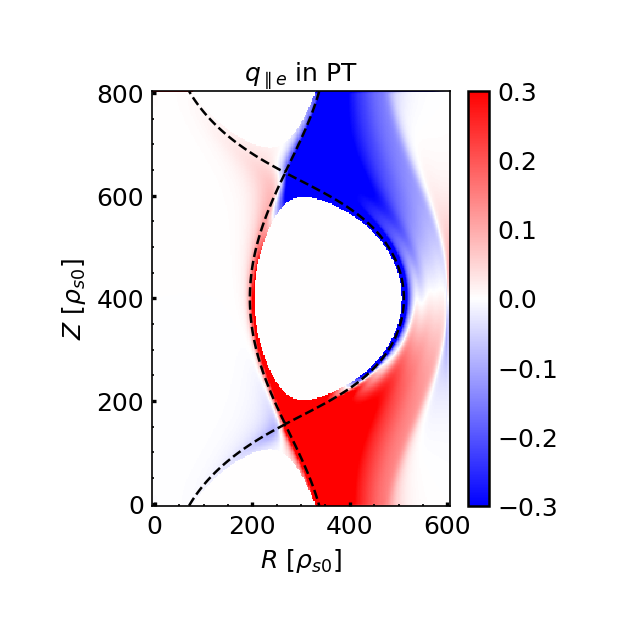

In [4]:
qpare_DPT_d0p6_masked = np.copy(qpare_DPT_d0p6)

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7500:
            qpare_DPT_d0p6_masked[i,j]=0.0
            
fig, ax = plt.subplots(figsize=(0.8,0.9), dpi=600)
X,Y = np.meshgrid(s.x, s.y)

cs=ax.pcolormesh(X, Y, qpare_DPT_d0p6_masked, cmap='bwr', vmin=-0.3, vmax=0.3, rasterized=True)




cbar = fig.colorbar(cs)
cbar.ax.tick_params(labelsize=3, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)


# Plot Separatrix
ax.contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linewidths=0.3, linestyles='--')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', direction="in", size=0.2, width=0.2)
ax.tick_params(which='major', direction="in", size=0.5, width=0.4)
ax.tick_params(axis='x', labelsize=3, pad=1)
ax.tick_params(axis='y', labelsize=3, pad=1)
ax.yaxis.get_offset_text().set_fontsize(2.5)
ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=3, labelpad=1)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=3, rotation=90, labelpad=1)

ax.spines["bottom"].set_linewidth(0.2)
ax.spines["left"].set_linewidth(0.2)
ax.spines["right"].set_linewidth(0.2)
ax.spines["top"].set_linewidth(0.2)

#ax.set_title(r'$\delta=+0.6$', fontsize=3, pad=1)
ax.set_title(r'$q_{\parallel e}$ in PT', fontsize=3, pad=1)

Text(0.5, 1.0, '$q_{\\parallel e}$ in PT')

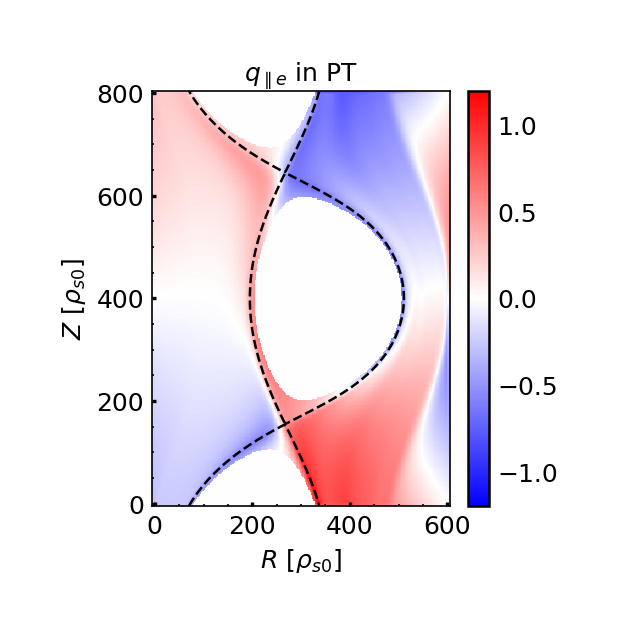

In [5]:
vpare_DPT_d0p6_masked = np.copy(np.mean(vpare_DPT_d0p6, axis=(2,3)))

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7500:
            vpare_DPT_d0p6_masked[i,j]=0.0
            
fig, ax = plt.subplots(figsize=(0.8,0.9), dpi=600)
X,Y = np.meshgrid(s.x, s.y)

cs=ax.pcolormesh(X, Y, vpare_DPT_d0p6_masked, cmap='bwr', vmin=-1.2, vmax=1.2, rasterized=True)
cbar = fig.colorbar(cs)
cbar.ax.tick_params(labelsize=3, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)

# Plot Separatrix
ax.contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linewidths=0.3, linestyles='--')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', direction="in", size=0.2, width=0.2)
ax.tick_params(which='major', direction="in", size=0.5, width=0.4)
ax.tick_params(axis='x', labelsize=3, pad=1)
ax.tick_params(axis='y', labelsize=3, pad=1)
ax.yaxis.get_offset_text().set_fontsize(2.5)
ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=3, labelpad=1)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=3, rotation=90, labelpad=1)

ax.spines["bottom"].set_linewidth(0.2)
ax.spines["left"].set_linewidth(0.2)
ax.spines["right"].set_linewidth(0.2)
ax.spines["top"].set_linewidth(0.2)

#ax.set_title(r'$\delta=+0.6$', fontsize=3, pad=1)
ax.set_title(r'$q_{\parallel e}$ in PT', fontsize=3, pad=1)

Text(0.5, 1.0, '$n$')

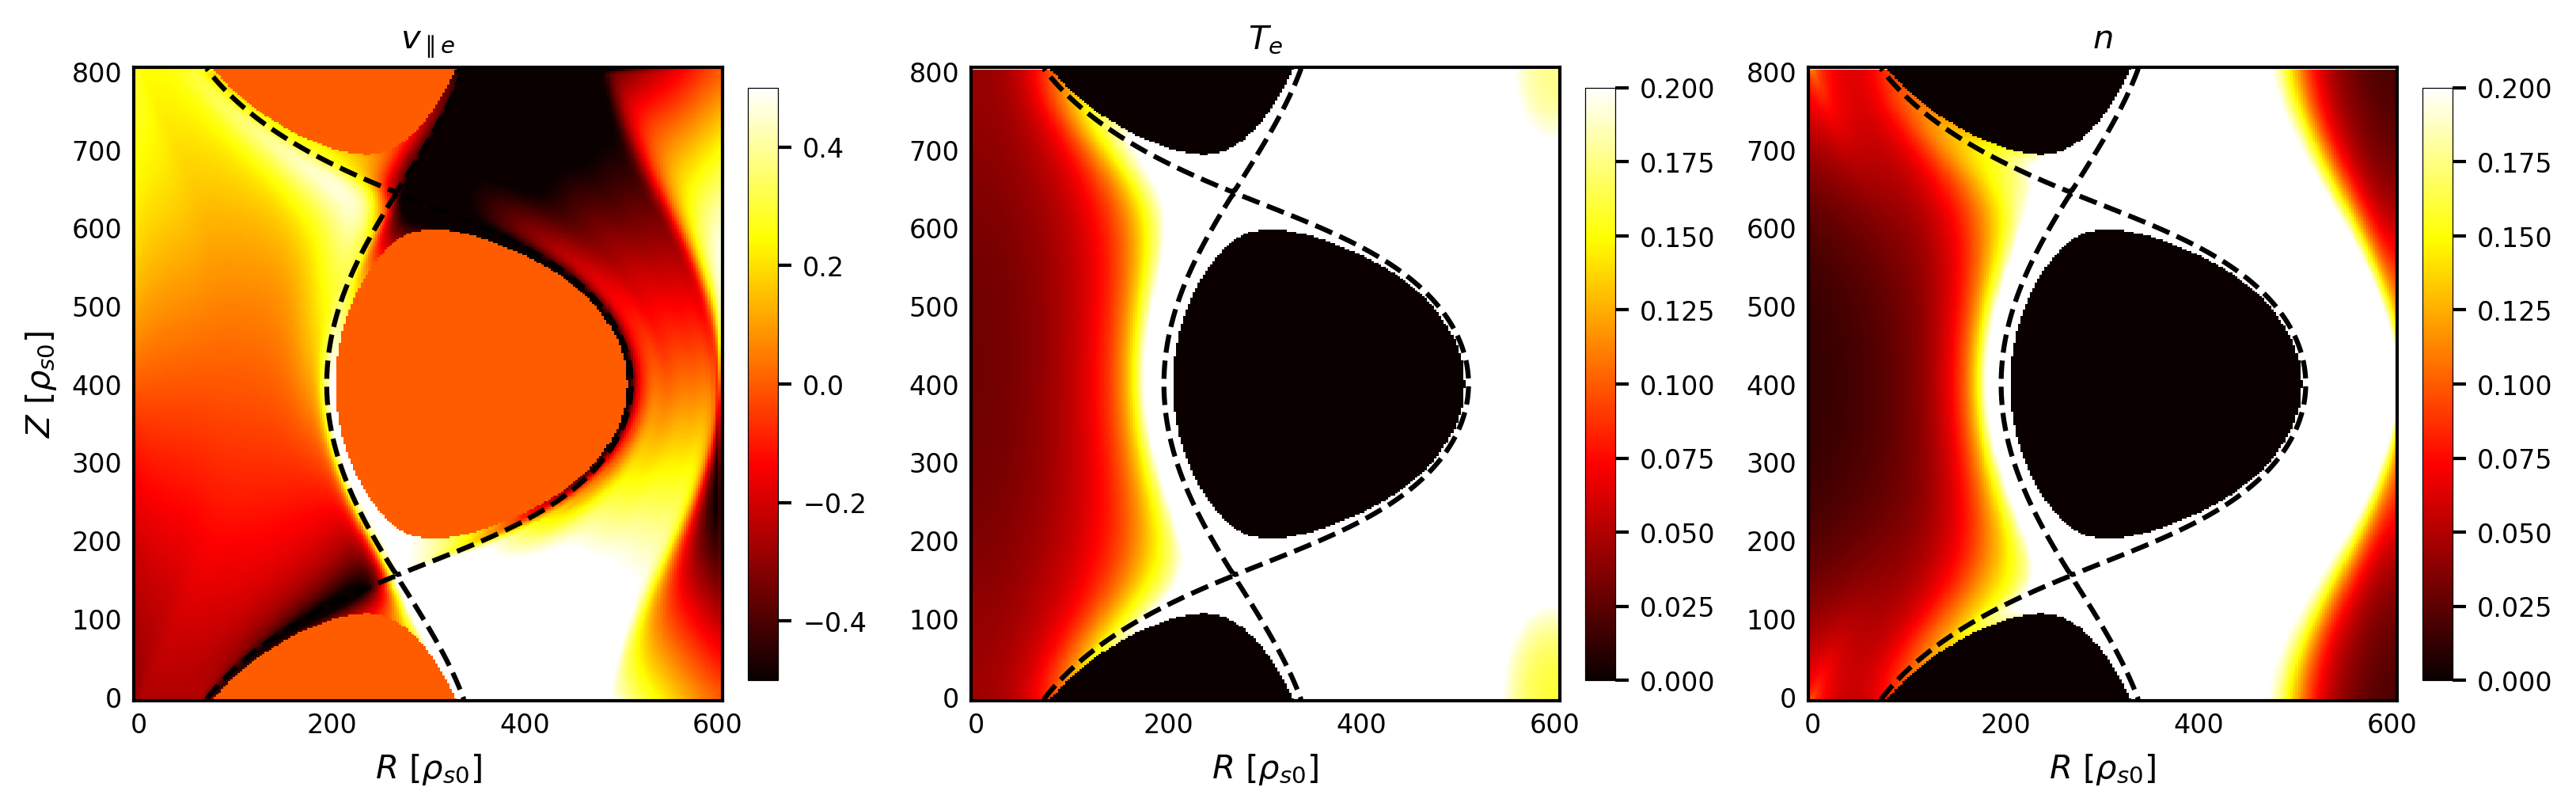

In [6]:
qpare_DPT_d0p6 = (5/2) * np.mean(vpare_DPT_d0p6 * Te_DPT_d0p6 * dens_DPT_d0p6, axis=(2,3))

vpare_DPT_d0p6_masked = np.copy(np.mean(vpare_DPT_d0p6, axis=(2,3)))
Te_DPT_d0p6_masked = np.copy(np.mean(Te_DPT_d0p6, axis=(2,3)))
dens_DPT_d0p6_masked = np.copy(np.mean(dens_DPT_d0p6, axis=(2,3)))

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7500:
            vpare_DPT_d0p6_masked[i,j]=0.0
            Te_DPT_d0p6_masked[i,j]=0.0
            dens_DPT_d0p6_masked[i,j]=0.0
            
fig, axes = plt.subplots(ncols=3, figsize=(3.6*fig_width, 1.6*fig_height))
X,Y = np.meshgrid(s.x, s.y)
plt.subplots_adjust(wspace=0.3)  # Adjust the width space

cs=axes[0].pcolormesh(X, Y, vpare_DPT_d0p6_masked, cmap='hot', vmin=-0.5, vmax=0.5, rasterized=True)
cs1=axes[1].pcolormesh(X, Y, Te_DPT_d0p6_masked, cmap='hot', vmin=0, vmax=0.2, rasterized=True)
cs2=axes[2].pcolormesh(X, Y, dens_DPT_d0p6_masked, cmap='hot', vmin=0, vmax=0.2, rasterized=True)

# Create a colorbar for each subplot
cbar = fig.colorbar(cs, ax=axes[0], fraction=0.046, pad=0.04)
cbar1 = fig.colorbar(cs1, ax=axes[1], fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(cs1, ax=axes[2], fraction=0.046, pad=0.04)

# Adjust colorbar properties
cbar.outline.set_linewidth(0.3)
cbar1.outline.set_linewidth(0.3)
cbar2.outline.set_linewidth(0.3)

for ax in axes:


    # Plot Separatrix
    ax.contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0.2, width=0.2)
    ax.tick_params(which='major', direction="in", size=0.5, width=0.4)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
    ax.set_xlabel(r'$R\,\,[\rho_{s0}]$')
axes[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', rotation=90)

axes[0].set_title(r'$v_{\parallel e}$')
axes[1].set_title(r'$T_e$')
axes[2].set_title(r'$n$')
#ax.set_title(r'$q_{\parallel e}$ in PT', fontsize=3, pad=1)

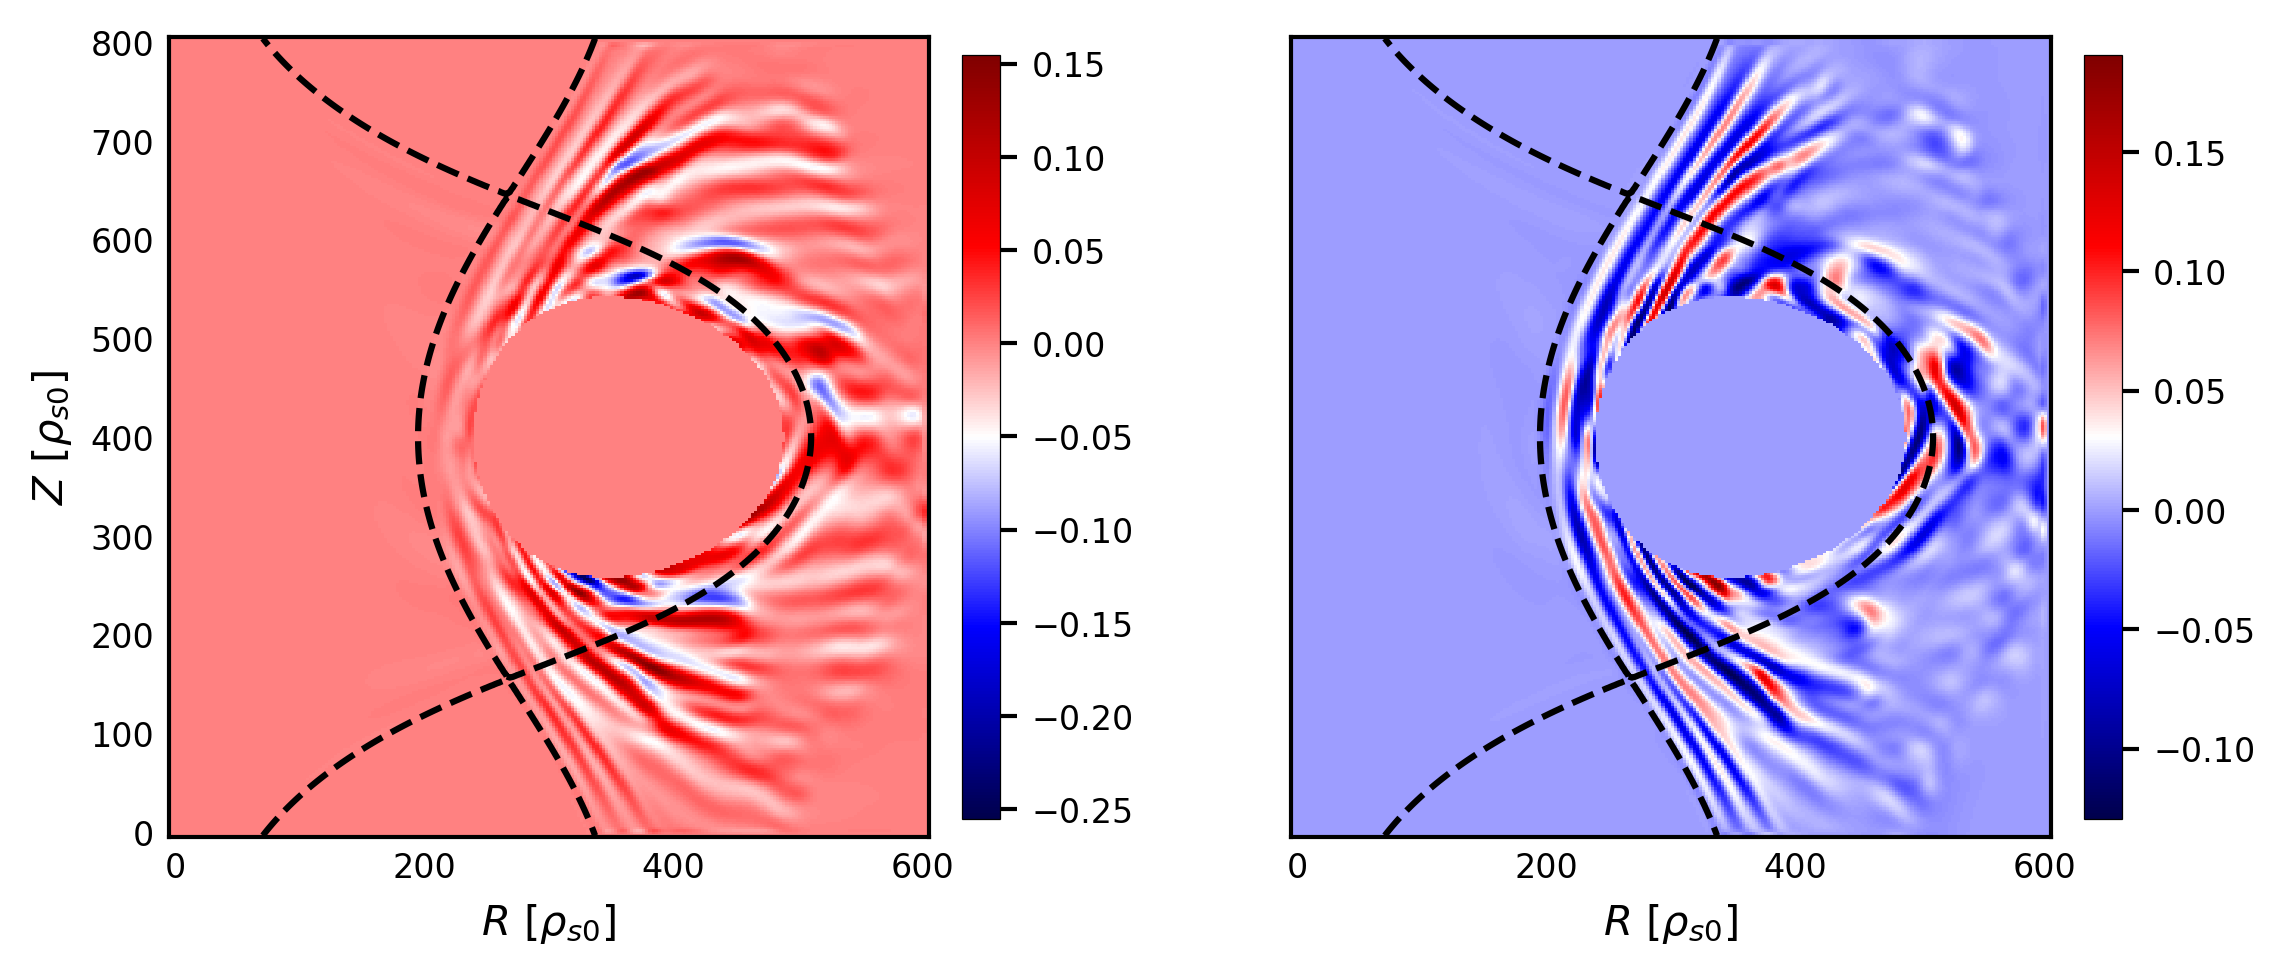

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(2.4*fig_width, 1.6*fig_height), sharey=True)
X,Y = np.meshgrid(s.x, s.y)

# Apply mask
phi_DPT_d0p6_fluct_diff_y_masked = np.copy(phi_DPT_d0p6_fluct_diff_y)
phi_DPT_d0p6_fluct_diff_x_masked = np.copy(phi_DPT_d0p6_fluct_diff_x)

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+6000:
            phi_DPT_d0p6_fluct_diff_y_masked[i,j]=0.0
            phi_DPT_d0p6_fluct_diff_x_masked[i,j]=0.0
            
cs = axes[0].pcolormesh(X, Y, phi_DPT_d0p6_fluct_diff_y_masked[:,:,0], cmap='seismic', rasterized=True)
cs1 = axes[1].pcolormesh(X, Y, -phi_DPT_d0p6_fluct_diff_x_masked[:,:,0], cmap='seismic', rasterized=True)

# Create a colorbar for each subplot
cbar = fig.colorbar(cs, ax=axes[0], fraction=0.046, pad=0.04)
cbar1 = fig.colorbar(cs1, ax=axes[1], fraction=0.046, pad=0.04)

# Adjust colorbar properties
cbar.outline.set_linewidth(0.3)
cbar1.outline.set_linewidth(0.3)


for ax in axes:
    # Plot Separatrix
    ax.contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0, width=0.2)
    ax.tick_params(which='major', direction="in", size=0, width=0.4)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    #ax.yaxis.get_offset_text().set_fontsize(2.5)
    ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
    ax.set_xlabel(r'$R\,\,[\rho_{s0}]$')
    

    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["top"].set_linewidth(1)

axes[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', rotation=90)
# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_PT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)

<div class="alert alert-block alert-info"  style="text-align: center;">
<span style="font-size: 40px;"><b> Now, Negative Triangularity (NT) </b></span><br>
</div>

<div class="alert alert-block alert-info"  style="text-align: center;">
<span style="font-size: 40px;"><b> NT -0.6 </b></span><br>
</div>

In [8]:
os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6')

# Load GBS simulations
s=g.Sim()

t_final = s.time[-1]
t_init = t_final -10
t_read = np.linspace(t_init, t_final, 101)

Psi_NT_dn0p6 = s.Psi
ixxpt_NT_dn0p6 = s.ixxpt
iyxpt_NT_dn0p6 = s.iyxpt
iy0_NT_dn0p6 = s.iy0
ix0_NT_dn0p6 = s.ix0

dens_DNT_dn0p6  = s.get_field('n', t1=t_init, t2=t_final)
vpare_DNT_dn0p6 = s.get_field('vpare', t1=t_init, t2=t_final)
Te_DNT_dn0p6 = s.get_field('Te', t1=t_init, t2=t_final)
phi_DNT_dn0p6 = s.get_field('strmf', t1=t_init, t2=t_final)

vpare_DNT_dn0p6_avg = np.mean(vpare_DNT_dn0p6, axis=(2,3))

# Fluctuating quantity
dens_DNT_dn0p6_avg  = np.mean(dens_DNT_dn0p6, axis=(2,3)); dens_DNT_dn0p6_avg_tor = np.mean(dens_DNT_dn0p6, axis=2)
dens_DNT_dn0p6_fluct   = np.sqrt((dens_DNT_dn0p6[:,:,0,:]-dens_DNT_dn0p6_avg_tor)**2) / dens_DNT_dn0p6_avg_tor
dens_DNT_dn0p6_fluct_avg = np.mean(dens_DNT_dn0p6_fluct, axis=2)

phi_DNT_dn0p6_avg  = np.mean(phi_DNT_dn0p6, axis=(2,3)); phi_DNT_dn0p6_avg_tor = np.mean(phi_DNT_dn0p6, axis=2)
phi_DNT_dn0p6_fluct   = np.sqrt((phi_DNT_dn0p6[:,:,0,:]-phi_DNT_dn0p6_avg_tor)**2) / phi_DNT_dn0p6_avg_tor
phi_DNT_dn0p6_fluct_avg = np.mean(phi_DNT_dn0p6_fluct, axis=2)

# Convective Heat Flux
qpare_DNT_dn0p6 = (5/2) * np.mean(vpare_DNT_dn0p6 * Te_DNT_dn0p6 * dens_DNT_dn0p6, axis=(2,3))

In [9]:
# For balanced DN
UO_DNT_dn0p6=(456.5503784658009, 709.075944151039)
UI_DNT_dn0p6=(310.36118514691896, 721.6963043686486)
LI_DNT_dn0p6=(310.3629879445284, 78.30729369710014)
LO_DNT_dn0p6=(456.5471511382758, 90.92656834368125)

coord_UI_DNT_dn0p6, length_UI_DNT_dn0p6 = get_line(s, UI_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))
coord_UO_DNT_dn0p6, length_UO_DNT_dn0p6 = get_line(s, UO_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))
coord_LI_DNT_dn0p6, length_LI_DNT_dn0p6 = get_line(s, LI_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))
coord_LO_DNT_dn0p6, length_LO_DNT_dn0p6 = get_line(s, LO_DNT_dn0p6, (-40,40), "psi", resolution=(40,40))

# Half length
#coord_xpt_up, length_xpt_up = get_line(s, (s.xxpt, s.yxpt), (-1,125), "chi", resolution=(40,125))
#coord_xpt_up2, length_xpt_up2 = get_line(s, (s.xxpt, s.yxpt), (-85,1), "chi", resolution=(40,40))
#coord_xpt_up3, length_xpt_up3 = get_line(s, (s.xxpt, 800-s.yxpt), (-1,85), "chi", resolution=(40,40))
#coord_xpt_up4, length_xpt_up4 = get_line(s, (s.xxpt, 800-s.yxpt), (-125,1), "chi", resolution=(40,40))


from scipy.interpolate import RectBivariateSpline
qpare_interpolant = RectBivariateSpline(s.y, s.x, qpare_DNT_dn0p6)
qpare_DNT_dn0p6_UI = qpare_interpolant(coord_UI_DNT_dn0p6[1,:], coord_UI_DNT_dn0p6[0,:], grid=False)
qpare_DNT_dn0p6_UO = qpare_interpolant(coord_UO_DNT_dn0p6[1,:], coord_UO_DNT_dn0p6[0,:], grid=False)
qpare_DNT_dn0p6_LI = qpare_interpolant(coord_LI_DNT_dn0p6[1,:], coord_LI_DNT_dn0p6[0,:], grid=False)
qpare_DNT_dn0p6_LO = qpare_interpolant(coord_LO_DNT_dn0p6[1,:], coord_LO_DNT_dn0p6[0,:], grid=False)

def calculate_heat_near_middle(array):
    middle_index = len(array) // 2
    start_index = max(middle_index - 40, 0)
    end_index = min(middle_index + 40, len(array))
    return np.abs(np.sum(array[start_index:end_index]))

# Apply the function to each array
Heat_DNT_dn0p6_LO = calculate_heat_near_middle(qpare_DNT_dn0p6_LO)
Heat_DNT_dn0p6_UO = calculate_heat_near_middle(qpare_DNT_dn0p6_UO)
Heat_DNT_dn0p6_LI = calculate_heat_near_middle(qpare_DNT_dn0p6_LI)
Heat_DNT_dn0p6_UI = calculate_heat_near_middle(qpare_DNT_dn0p6_UI)

# Peak Heat Flux
Peak_DNT_dn0p6_LO = np.max(np.abs(qpare_DNT_dn0p6_LO))
Peak_DNT_dn0p6_UO = np.max(np.abs(qpare_DNT_dn0p6_UO))
Peak_DNT_dn0p6_LI = np.max(np.abs(qpare_DNT_dn0p6_LI))
Peak_DNT_dn0p6_UI = np.max(np.abs(qpare_DNT_dn0p6_UI))

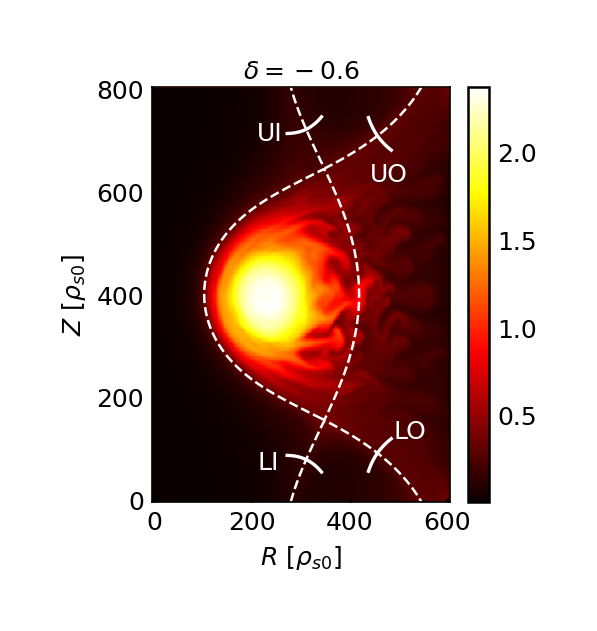

In [10]:
fig, ax = plt.subplots(figsize=(0.8,0.9), dpi=600)
X,Y = np.meshgrid(s.x, s.y)
#vmin=0; vmax=2

#cs=ax.pcolormesh(X, Y, dens_DNT_dn0p6[:,:,0,0], cmap='hot', vmin=vmin, vmax=vmax)
cs=ax.pcolormesh(X, Y, dens_DNT_dn0p6[:,:,0,-1], cmap='hot', rasterized=True)
#cs=ax.pcolormesh(X, Y, dens_DNT_dn0p6_fluct_avg, cmap='hot', rasterized=True)
#cs=ax.pcolormesh(X, Y, phi_DNT_dn0p6[:,:,0,-1], cmap='hot_r', rasterized=True)
#cs=ax.pcolormesh(X, Y, qpare_DNT_dn0p6, cmap='seismic', vmin=-1, vmax=1, rasterized=True)
##cs=ax.pcolormesh(X, Y, vpare_DNT_dn0p6_avg, cmap='hot', vmin=0, vmax=1, rasterized=True)


ax.plot(coord_UI_DNT_dn0p6[0,:], coord_UI_DNT_dn0p6[1,:], c='w', linestyle='-', linewidth=0.4)
ax.plot(coord_UO_DNT_dn0p6[0,:], coord_UO_DNT_dn0p6[1,:], c='w', linestyle='-', linewidth=0.4)
ax.plot(coord_LI_DNT_dn0p6[0,:], coord_LI_DNT_dn0p6[1,:], c='w', linestyle='-', linewidth=0.4)
ax.plot(coord_LO_DNT_dn0p6[0,:], coord_LO_DNT_dn0p6[1,:], c='w', linestyle='-', linewidth=0.4)

cbar = fig.colorbar(cs)

#cbar.ax.set_ylabel(r'Growth rate $\gamma$', fontsize=2, labelpad=1) # Colorbar y-label
cbar.ax.tick_params(labelsize=3, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)


# Plot Separatrix
ax.contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='w', linewidths=0.3, linestyles='--')

#ax.plot(coord_xpt_up[0,:], coord_xpt_up[1,:], c='yellow', linestyle='-', linewidth=0.4)
#ax.plot(coord_xpt_up2[0,:], coord_xpt_up2[1,:], c='m', linestyle='-', linewidth=0.4)
#ax.plot(coord_xpt_up3[0,:], coord_xpt_up3[1,:], c='lime', linestyle='-', linewidth=0.4)
#ax.plot(coord_xpt_up4[0,:], coord_xpt_up4[1,:], c='cyan', linestyle='-', linewidth=0.4)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', direction="in", size=0.2, width=0.2)
ax.tick_params(which='major', direction="in", size=0.5, width=0.4)
ax.tick_params(axis='x', labelsize=3, pad=1)
ax.tick_params(axis='y', labelsize=3, pad=1)
ax.yaxis.get_offset_text().set_fontsize(2.5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=3, labelpad=1)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=3, rotation=90, labelpad=1)
#ax.set_title(r'DN', fontsize=3, pad=1)
ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks


ax.spines["bottom"].set_linewidth(0.2)
ax.spines["left"].set_linewidth(0.2)
ax.spines["right"].set_linewidth(0.2)
ax.spines["top"].set_linewidth(0.2)

ax.text(490, 120, 'LO', style ='normal', family='sans-serif', fontsize = 3, color ="w")
ax.text(210, 60, 'LI', style ='normal', family='sans-serif', fontsize = 3, color ="w")
ax.text(440, 620, 'UO', style ='normal', family='sans-serif', fontsize = 3, color ="w")
ax.text(210, 700, 'UI', style ='normal', family='sans-serif', fontsize = 3, color ="w")


ax.set_title(r'$\delta=-0.6$', fontsize=3, pad=1)
#ax.set_title(r'$q_{\parallel,e}$', fontsize=3, pad=1)

# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_NT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)

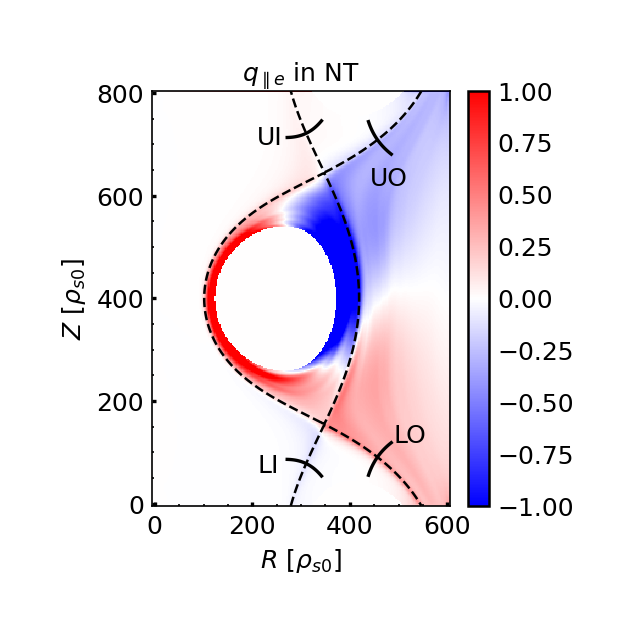

In [11]:
qpare_DNT_dn0p6_masked = np.copy(qpare_DNT_dn0p6)

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_NT_dn0p6[i,j] < Psi_NT_dn0p6[iy0_NT_dn0p6,ix0_NT_dn0p6]+6000:
            qpare_DNT_dn0p6_masked[i,j]=0.0


fig, ax = plt.subplots(figsize=(0.8,0.9), dpi=600)
X,Y = np.meshgrid(s.x, s.y)
#vmin=0; vmax=2

#cs=ax.pcolormesh(X, Y, dens_DNT_d0p6[:,:,0,0], cmap='hot', vmin=vmin, vmax=vmax)
#cs=ax.pcolormesh(X, Y, dens_DNT_d0p6[:,:,0,0], cmap='hot', rasterized=True)
#cs=ax.pcolormesh(X, Y, dens_DNT_d0p6_fluct_avg, cmap='hot', rasterized=True)
#cs=ax.pcolormesh(X, Y, phi_DNT_d0p6[:,:,0,-1], cmap='hot_r', rasterized=True)
cs=ax.pcolormesh(X, Y, qpare_DNT_dn0p6_masked, cmap='bwr', vmin=-1, vmax=1, rasterized=True)
#cs=ax.pcolormesh(X, Y, vpare_DNT_d0p6_avg, cmap='hot', vmin=0, vmax=1, rasterized=True)


ax.plot(coord_UI_DNT_dn0p6[0,:], coord_UI_DNT_dn0p6[1,:], c='k', linestyle='-', linewidth=0.4)
ax.plot(coord_UO_DNT_dn0p6[0,:], coord_UO_DNT_dn0p6[1,:], c='k', linestyle='-', linewidth=0.4)
ax.plot(coord_LI_DNT_dn0p6[0,:], coord_LI_DNT_dn0p6[1,:], c='k', linestyle='-', linewidth=0.4)
ax.plot(coord_LO_DNT_dn0p6[0,:], coord_LO_DNT_dn0p6[1,:], c='k', linestyle='-', linewidth=0.4)

cbar = fig.colorbar(cs)

#cbar.ax.set_ylabel(r'Growth rate $\gamma$', fontsize=2, labelpad=1) # Colorbar y-label
cbar.ax.tick_params(labelsize=3, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)


# Plot Separatrix
ax.contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linewidths=0.3, linestyles='--')

#ax.plot(coord_xpt_up[0,:], coord_xpt_up[1,:], c='yellow', linestyle='-', linewidth=0.4)
#ax.plot(coord_xpt_up2[0,:], coord_xpt_up2[1,:], c='m', linestyle='-', linewidth=0.4)
#ax.plot(coord_xpt_up3[0,:], coord_xpt_up3[1,:], c='lime', linestyle='-', linewidth=0.4)
#ax.plot(coord_xpt_up4[0,:], coord_xpt_up4[1,:], c='cyan', linestyle='-', linewidth=0.4)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', direction="in", size=0.2, width=0.2)
ax.tick_params(which='major', direction="in", size=0.5, width=0.4)
ax.tick_params(axis='x', labelsize=3, pad=1)
ax.tick_params(axis='y', labelsize=3, pad=1)
ax.yaxis.get_offset_text().set_fontsize(2.5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=3, labelpad=1)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=3, rotation=90, labelpad=1)
#ax.set_title(r'DN', fontsize=3, pad=1)
ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks


ax.spines["bottom"].set_linewidth(0.2)
ax.spines["left"].set_linewidth(0.2)
ax.spines["right"].set_linewidth(0.2)
ax.spines["top"].set_linewidth(0.2)

ax.text(490, 120, 'LO', style ='normal', family='sans-serif', fontsize = 3, color ="k")
ax.text(210, 60, 'LI', style ='normal', family='sans-serif', fontsize = 3, color ="k")
ax.text(440, 620, 'UO', style ='normal', family='sans-serif', fontsize = 3, color ="k")
ax.text(210, 700, 'UI', style ='normal', family='sans-serif', fontsize = 3, color ="k")


#ax.set_title(r'$\delta=-0.6$', fontsize=3, pad=1)
ax.set_title(r'$q_{\parallel e}$ in NT', fontsize=3, pad=1)

# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_NT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)

<div class="alert alert-block alert-info"  style="text-align: center;">
<span style="font-size: 40px;"><b> Now figures for the paper </b></span><br>
</div>

In [12]:
# IEEE journals typically require figures to be very clear at a column width of around 3.5 to 4 inches
fig_width = 3.5  # in inches
fig_height = fig_width / 1.618  # Golden ratio height for a single subplot

plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (fig_width, fig_width / 1.618),  # IEEE column width, golden ratio height
    'figure.dpi': 300,                     # Figure resolution
    'savefig.dpi': 300,                    # Save figure resolution
    'savefig.format': 'pdf',               # Preferred format for vector graphics

    # Font settings
    'font.size': 10,                       # Main font size
    'font.family': 'sans-serif',           # Font family
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],  # Font type

    # Axes settings
    'axes.labelsize': 10,                  # Font size of the x and y labels
    'axes.titlesize': 10,                  # Font size of the title
    'axes.linewidth': 1,                   # Edge line width

    # Tick settings
    'xtick.labelsize': 8,                  # Font size of the x tick labels
    'ytick.labelsize': 8,                  # Font size of the y tick labels
    'xtick.major.size': 4,                 # Length of major tick marks
    'xtick.minor.size': 2,                 # Length of minor tick marks
    'xtick.major.width': 1,                # Width of major tick marks
    'xtick.minor.width': 0.5,              # Width of minor tick marks
    'ytick.major.size': 4,                 # Length of major tick marks
    'ytick.minor.size': 2,                 # Length of minor tick marks
    'ytick.major.width': 1,                # Width of major tick marks
    'ytick.minor.width': 0.5,              # Width of minor tick marks

    # Legend settings
    'legend.fontsize': 8,                  # Font size of the legend
    'legend.frameon': True,               # Disable background frame
    'legend.edgecolor':'white',

    # Line settings
    'lines.linewidth': 1.5,                # Line width
    'lines.markersize': 5,                 # Marker size

    # Grid settings
    'grid.alpha': 0.5,                     # Grid line transparency
    'grid.linestyle': ':',                 # Grid line style

})


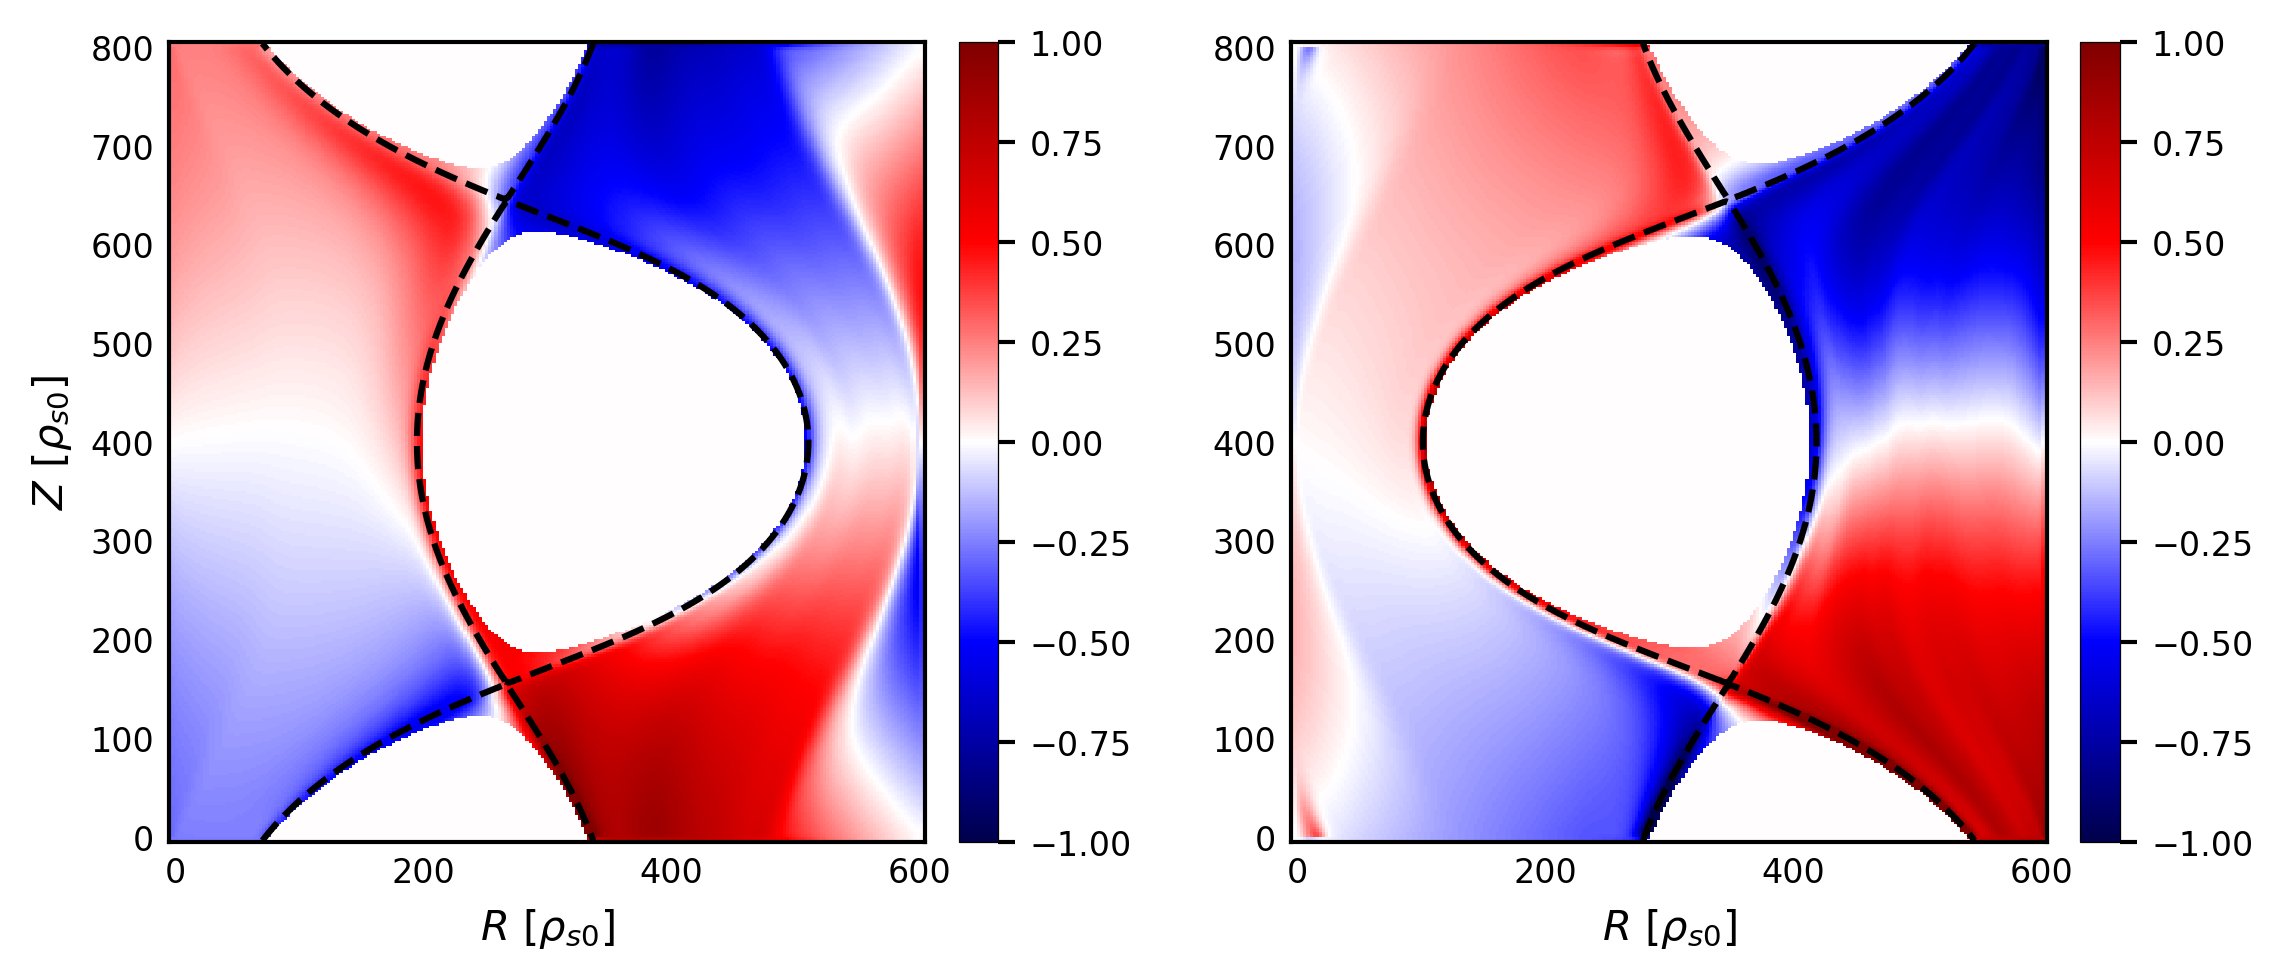

In [13]:
vpare_DPT_d0p6_masked = np.copy(np.mean(vpare_DPT_d0p6, axis=(2,3)))
vpare_DNT_dn0p6_masked = np.copy(np.mean(vpare_DNT_dn0p6, axis=(2,3)))

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7700:
            vpare_DPT_d0p6_masked[i,j]=0.0
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_NT_dn0p6[i,j] < Psi_NT_dn0p6[iy0_NT_dn0p6,ix0_NT_dn0p6]+7700:
            vpare_DNT_dn0p6_masked[i,j]=0.0
        
            
fig, axes = plt.subplots(ncols=2, figsize=(2.4*fig_width, 1.6*fig_height))
X,Y = np.meshgrid(s.x, s.y)
   
cs = axes[0].pcolormesh(X, Y, vpare_DPT_d0p6_masked, cmap='seismic', vmin=-1., vmax=1., rasterized=True)
cs1 = axes[1].pcolormesh(X, Y, vpare_DNT_dn0p6_masked, cmap='seismic', vmin=-1., vmax=1., rasterized=True)

# Create a colorbar for each subplot
cbar = fig.colorbar(cs, ax=axes[0], fraction=0.05, pad=0.04)
cbar1 = fig.colorbar(cs1, ax=axes[1], fraction=0.05, pad=0.04)

# Adjust colorbar properties
cbar.outline.set_linewidth(0.3)
cbar1.outline.set_linewidth(0.3)


for ax in axes:
    # Plot Separatrix
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0, width=0.2)
    ax.tick_params(which='major', direction="in", size=0, width=0.4)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    #ax.yaxis.get_offset_text().set_fontsize(2.5)
    ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
    ax.set_xlabel(r'$R\,\,[\rho_{s0}]$')
    

    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["top"].set_linewidth(1)

axes[0].contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
axes[1].contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linestyles='--')

axes[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', rotation=90)
# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_PT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)

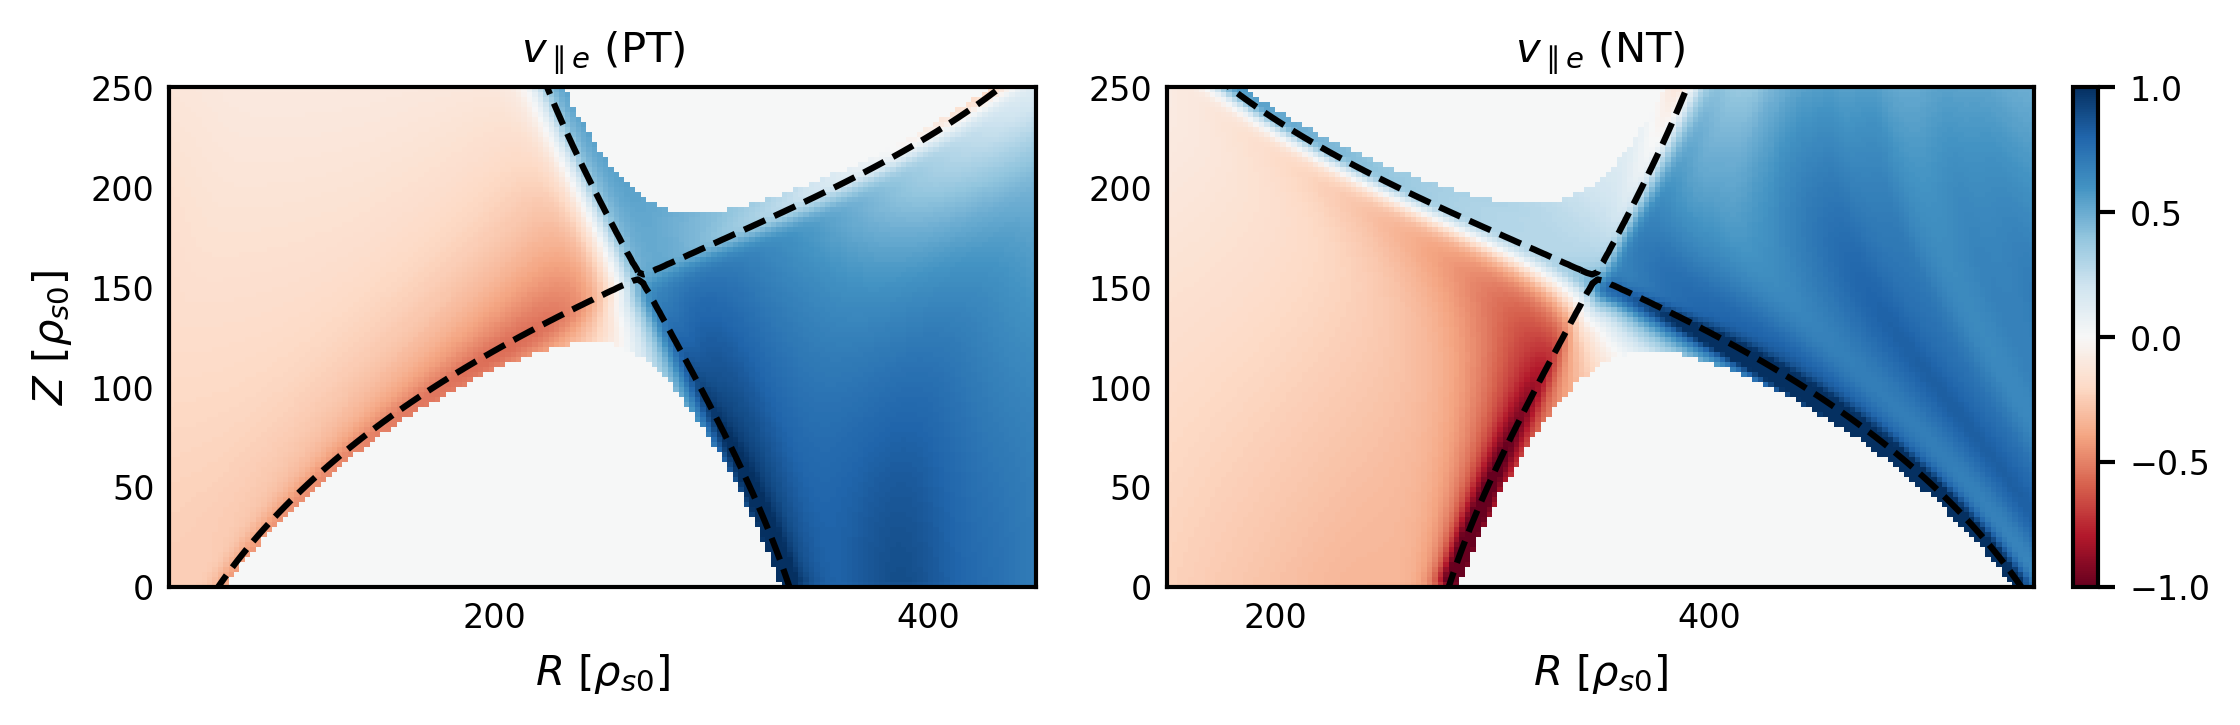

In [14]:
vpare_DPT_d0p6_masked = np.copy(np.mean(vpare_DPT_d0p6, axis=(2,3)))
vpare_DNT_dn0p6_masked = np.copy(np.mean(vpare_DNT_dn0p6, axis=(2,3)))

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7700:
            vpare_DPT_d0p6_masked[i,j]=0.0
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_NT_dn0p6[i,j] < Psi_NT_dn0p6[iy0_NT_dn0p6,ix0_NT_dn0p6]+7700:
            vpare_DNT_dn0p6_masked[i,j]=0.0
        
            
fig, axes = plt.subplots(ncols=2, figsize=(2.4*fig_width, fig_height))
X,Y = np.meshgrid(s.x, s.y)
plt.subplots_adjust(wspace=0.15)  # Adjust the width space

cs = axes[0].pcolormesh(X, Y, vpare_DPT_d0p6_masked, cmap='RdBu', vmin=-1., vmax=1., rasterized=True)
cs1 = axes[1].pcolormesh(X, Y, vpare_DNT_dn0p6_masked, cmap='RdBu', vmin=-1., vmax=1., rasterized=True)

# Remove the individual colorbars and create one for both subplots
fig.colorbar(cs, ax=axes, fraction=0.025, pad=0.02)


for ax in axes:
    # Plot Separatrix
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0, width=0.2)
    ax.tick_params(which='major', direction="in", size=0, width=0.4)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    #ax.yaxis.get_offset_text().set_fontsize(2.5)
    ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
    ax.set_xlabel(r'$R\,\,[\rho_{s0}]$')
    

    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["top"].set_linewidth(1)

axes[0].contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
axes[1].contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linestyles='--')
axes[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', rotation=90)


axes[0].set_xlim([50,450]); axes[0].set_ylim([0,250])
axes[1].set_xlim([150,550]); axes[1].set_ylim([0,250])

axes[0].set_title(r'$v_{\parallel e}$ (PT)')
axes[1].set_title(r'$v_{\parallel e}$ (NT)')
# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_PT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)

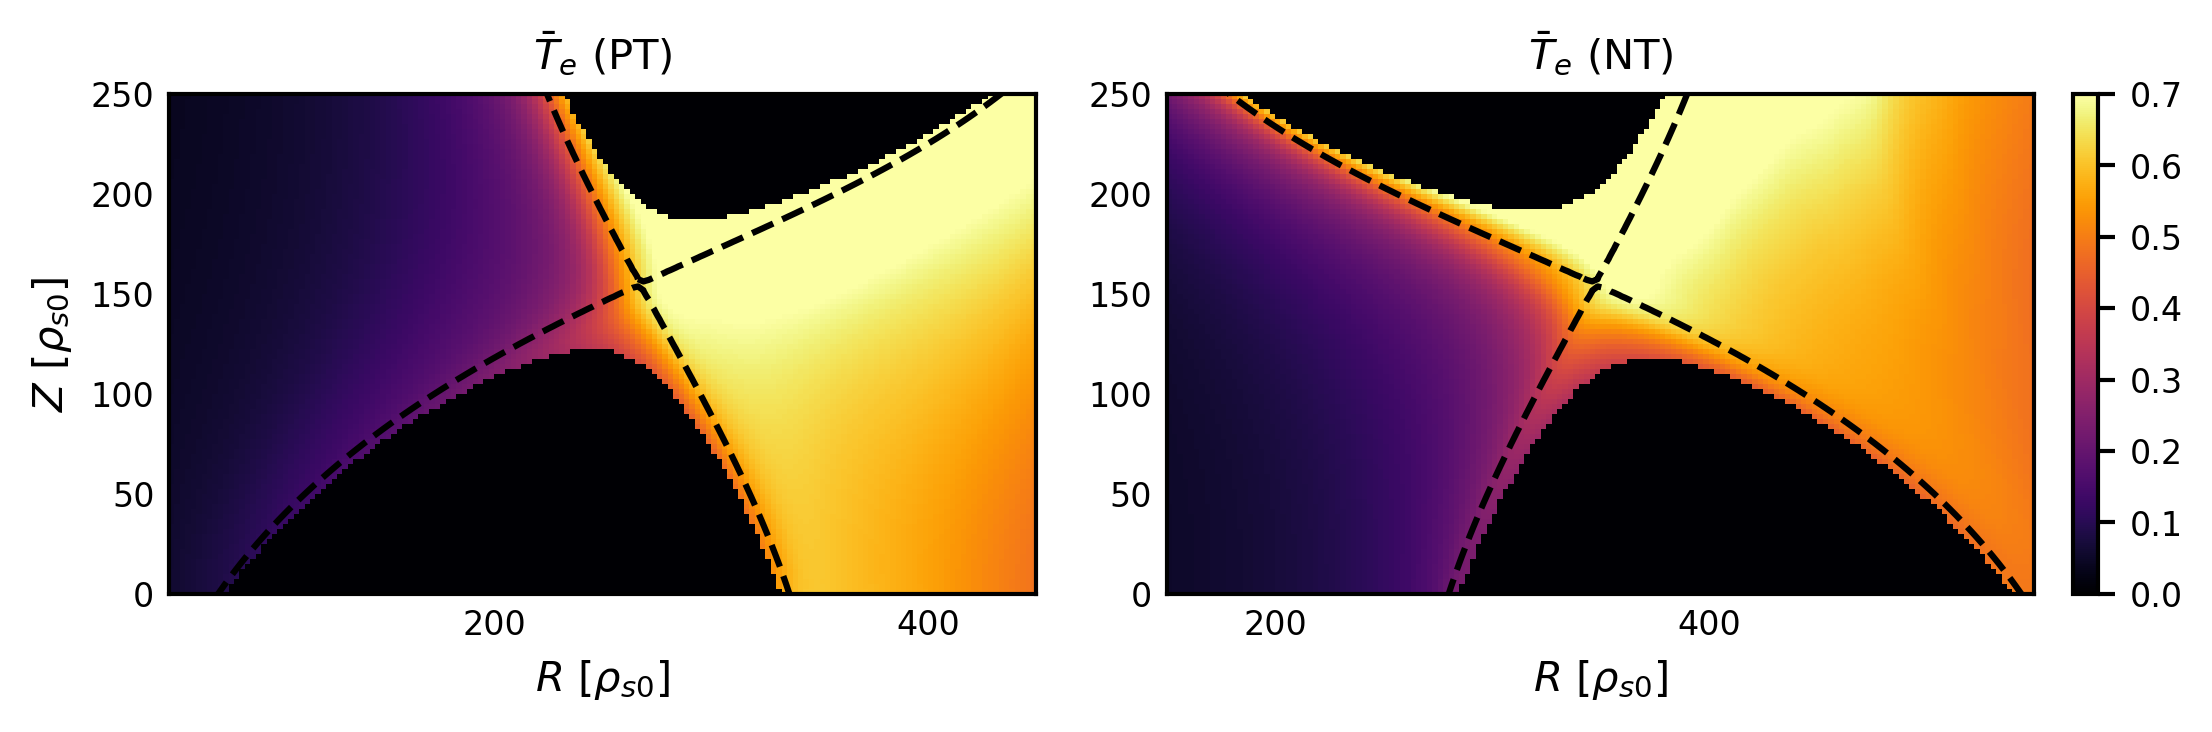

In [15]:
Te_DPT_d0p6_masked = np.copy(np.mean(Te_DPT_d0p6, axis=(2,3)))
Te_DNT_dn0p6_masked = np.copy(np.mean(Te_DNT_dn0p6, axis=(2,3)))

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7700:
            Te_DPT_d0p6_masked[i,j]=0.0
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_NT_dn0p6[i,j] < Psi_NT_dn0p6[iy0_NT_dn0p6,ix0_NT_dn0p6]+7700:
            Te_DNT_dn0p6_masked[i,j]=0.0

        
        
fig, axes = plt.subplots(ncols=2, figsize=(2.4*fig_width, fig_height))
X,Y = np.meshgrid(s.x, s.y)
plt.subplots_adjust(wspace=0.15)  # Adjust the width space

# Plotting data with the same vmin and vmax for consistency
cs = axes[0].pcolormesh(X, Y, Te_DPT_d0p6_masked, cmap='inferno', vmin=0., vmax=0.7, rasterized=True)
cs1 = axes[1].pcolormesh(X, Y, Te_DNT_dn0p6_masked, cmap='inferno', vmin=0., vmax=0.7, rasterized=True)


# Remove the individual colorbars and create one for both subplots
fig.colorbar(cs, ax=axes, fraction=0.025, pad=0.02)

for ax in axes:
    # Plot Separatrix
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0, width=0.2)
    ax.tick_params(which='major', direction="in", size=0, width=0.4)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    #ax.yaxis.get_offset_text().set_fontsize(2.5)
    ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
    ax.set_xlabel(r'$R\,\,[\rho_{s0}]$')
    

    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["top"].set_linewidth(1)

axes[0].contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
axes[1].contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linestyles='--')
axes[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', rotation=90)


axes[0].set_xlim([50,450]); axes[0].set_ylim([0,250])
axes[1].set_xlim([150,550]); axes[1].set_ylim([0,250])

axes[0].set_title(r'$\bar{T}_e$ (PT)')
axes[1].set_title(r'$\bar{T}_e$ (NT)')
# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_PT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)

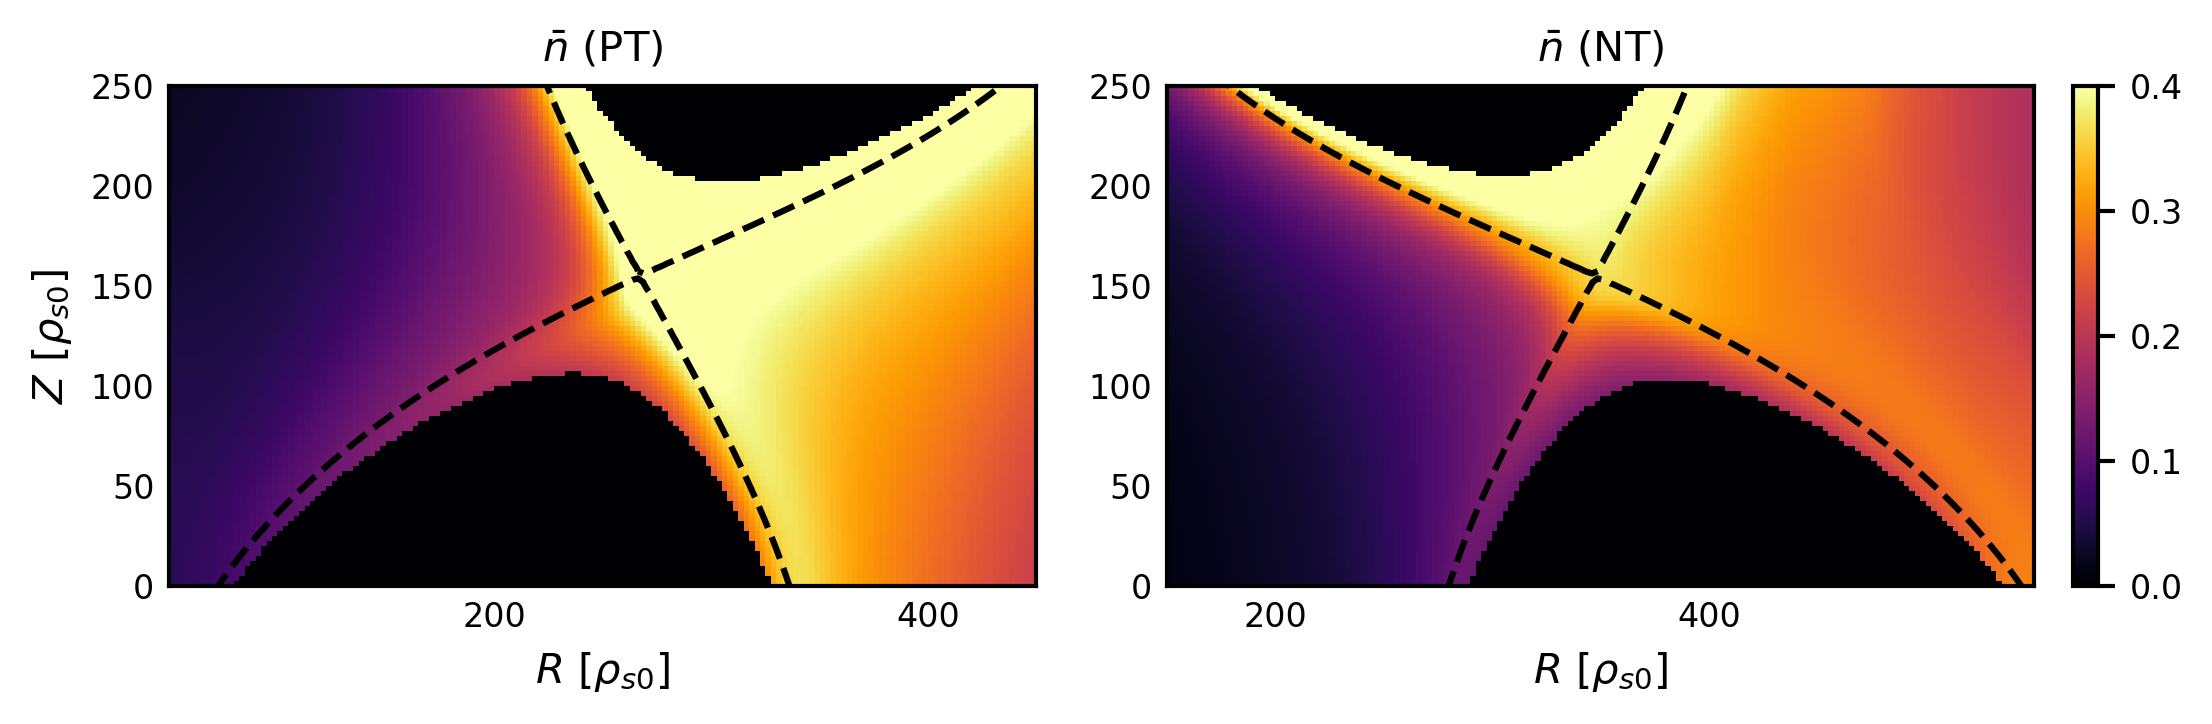

In [16]:
dens_DPT_d0p6_masked = np.copy(np.mean(dens_DPT_d0p6, axis=(2,3)))
dens_DNT_dn0p6_masked = np.copy(np.mean(dens_DNT_dn0p6, axis=(2,3)))

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7500:
            dens_DPT_d0p6_masked[i,j]=0.0
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_NT_dn0p6[i,j] < Psi_NT_dn0p6[iy0_NT_dn0p6,ix0_NT_dn0p6]+7500:
            dens_DNT_dn0p6_masked[i,j]=0.0
            
            
            
fig, axes = plt.subplots(ncols=2, figsize=(2.4*fig_width, fig_height))
X,Y = np.meshgrid(s.x, s.y)
plt.subplots_adjust(wspace=0.15)  # Adjust the width space

   
# Plotting data with the same vmin and vmax for consistency
cs = axes[0].pcolormesh(X, Y, dens_DPT_d0p6_masked, cmap='inferno', vmin=0., vmax=0.4, rasterized=True)
cs1 = axes[1].pcolormesh(X, Y, dens_DNT_dn0p6_masked, cmap='inferno', vmin=0., vmax=0.4, rasterized=True)

# Remove the individual colorbars and create one for both subplots
fig.colorbar(cs, ax=axes, fraction=0.025, pad=0.02)


for ax in axes:
    # Plot Separatrix
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0, width=0.2)
    ax.tick_params(which='major', direction="in", size=0, width=0.4)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    #ax.yaxis.get_offset_text().set_fontsize(2.5)
    ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks
    ax.set_xlabel(r'$R\,\,[\rho_{s0}]$')
    

    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["top"].set_linewidth(1)

axes[0].contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
axes[1].contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linestyles='--')
axes[0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', rotation=90)


axes[0].set_xlim([50,450]); axes[0].set_ylim([0,250])
axes[1].set_xlim([150,550]); axes[1].set_ylim([0,250])

axes[0].set_title(r'$\bar{n}$ (PT)')
axes[1].set_title(r'$\bar{n}$ (NT)')
# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_PT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)

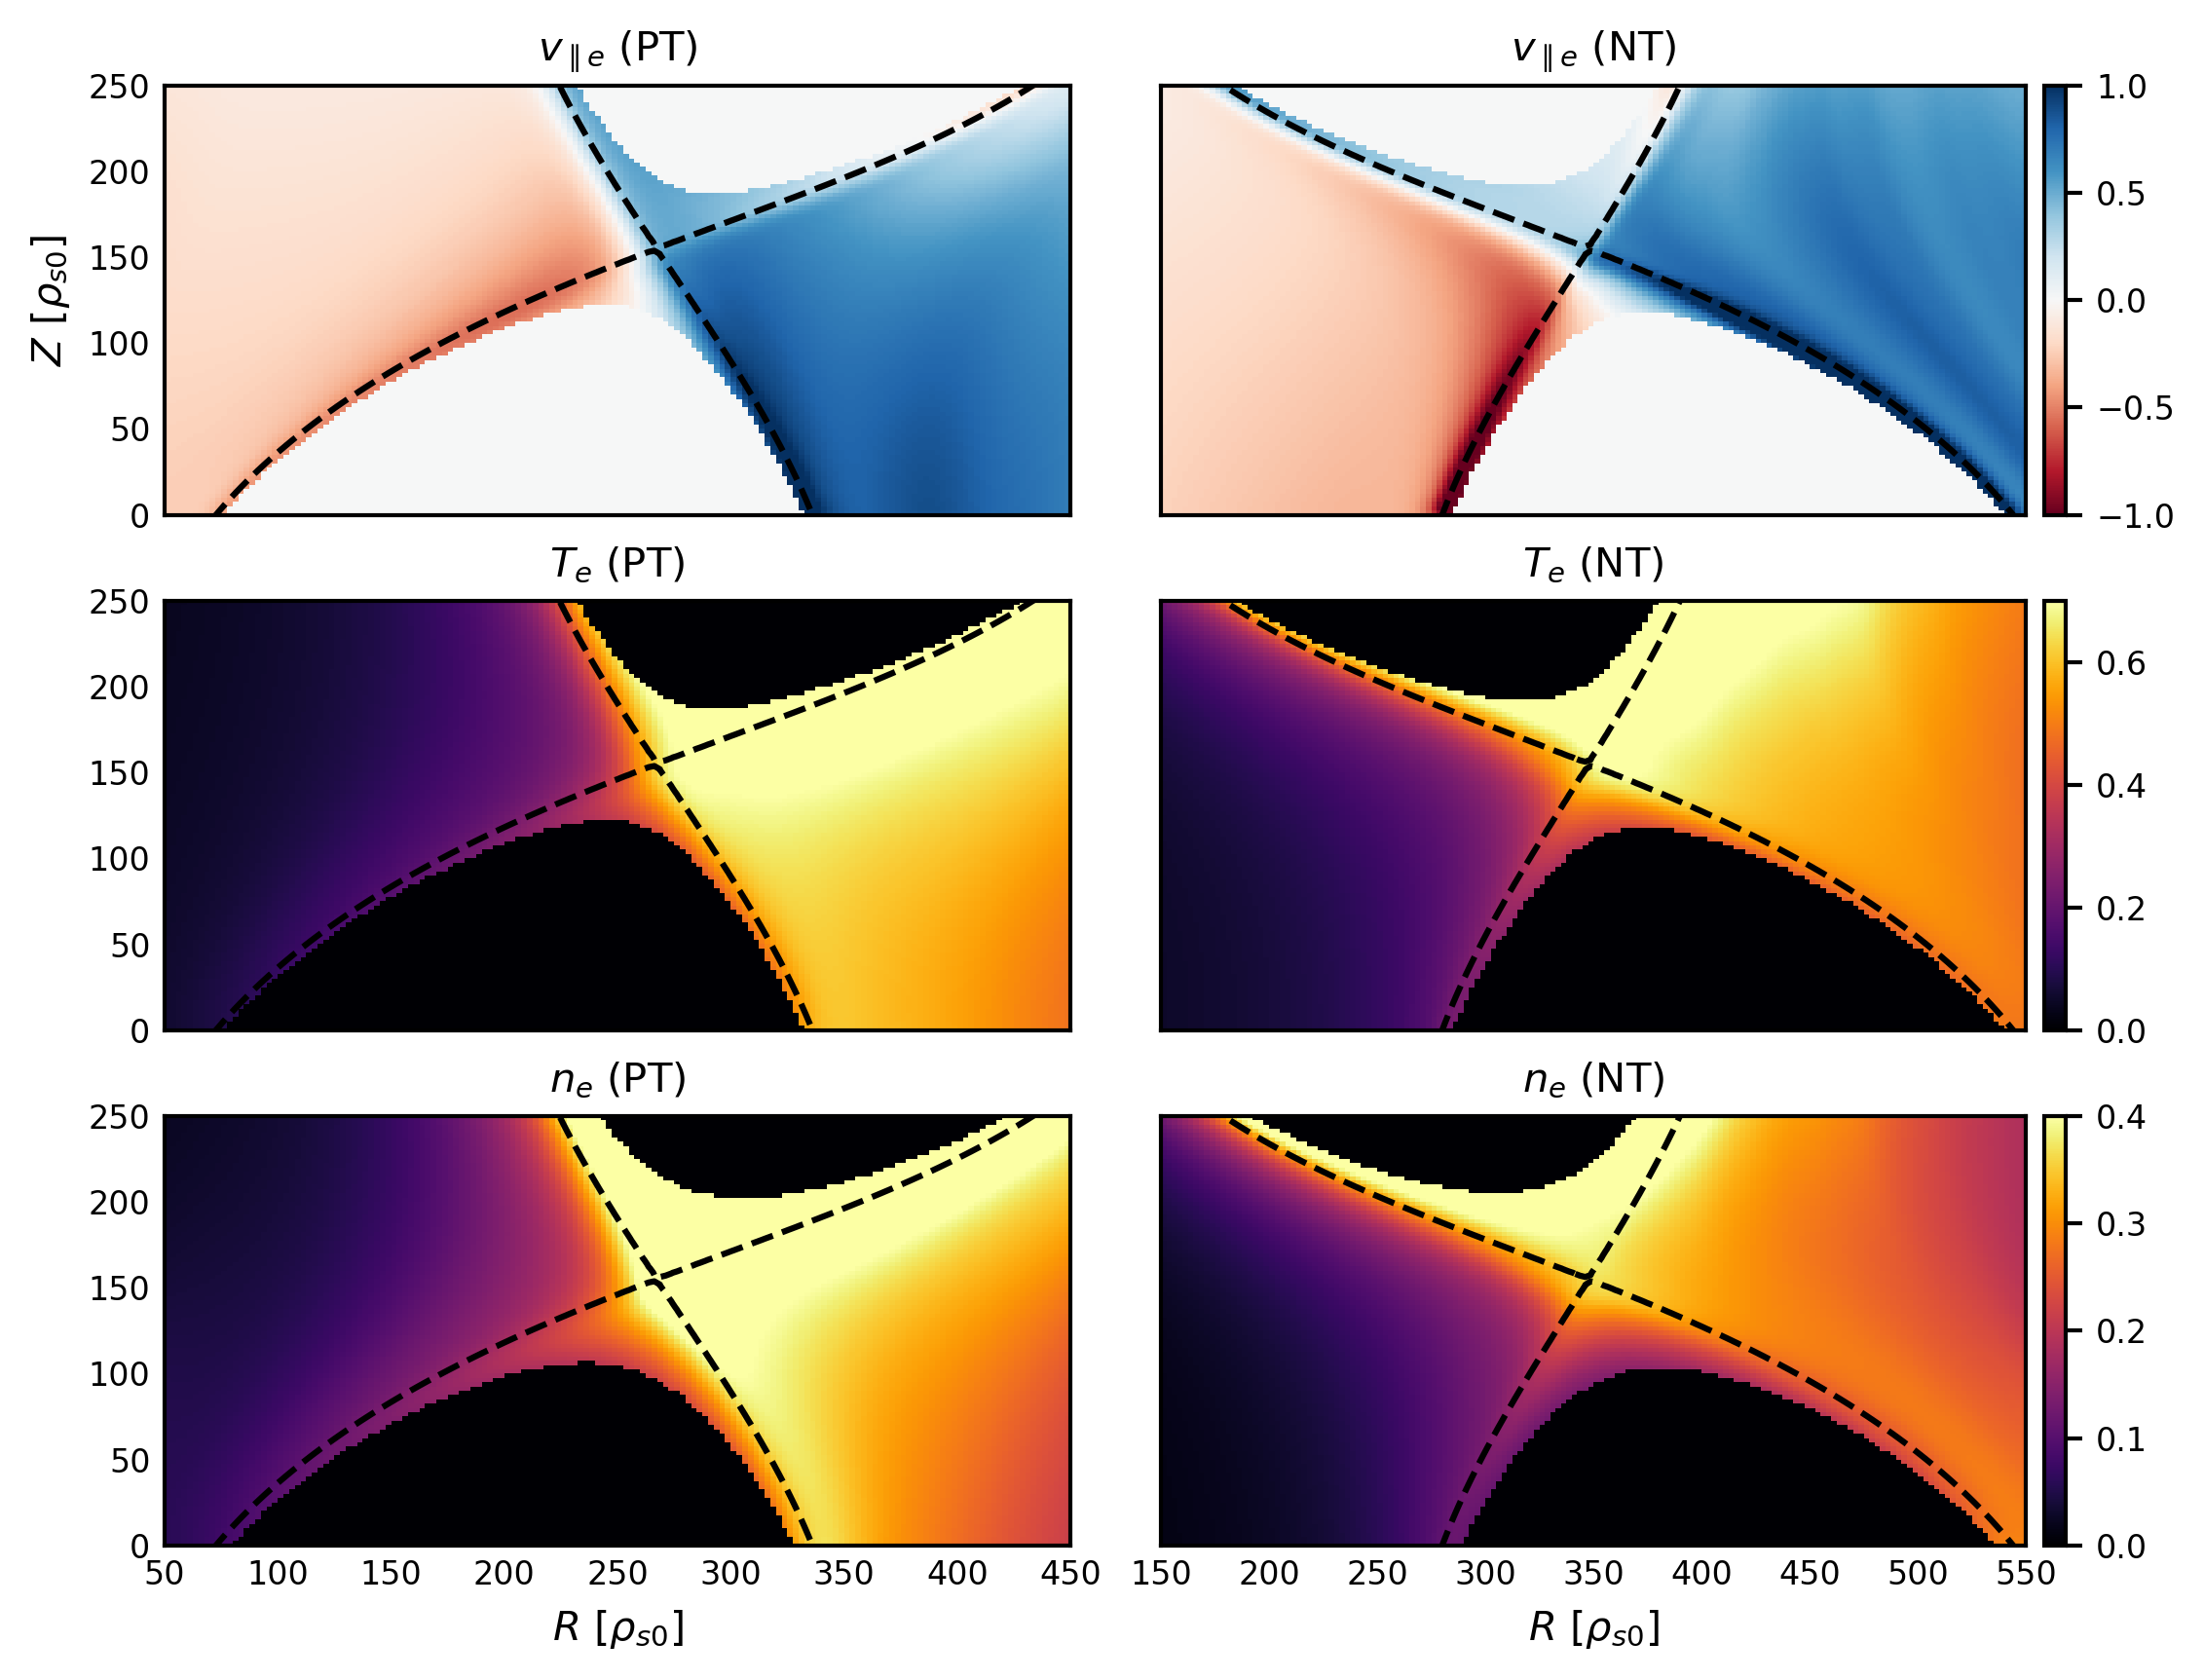

In [17]:
vpare_DPT_d0p6_masked = np.copy(np.mean(vpare_DPT_d0p6, axis=(2,3)))
vpare_DNT_dn0p6_masked = np.copy(np.mean(vpare_DNT_dn0p6, axis=(2,3)))

# Apply mask for the core region
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_PT_d0p6[i,j] < Psi_PT_d0p6[iy0_PT_d0p6,ix0_PT_d0p6]+7700:
            vpare_DPT_d0p6_masked[i,j]=0.0
for i in range(s.ny):
    for j in range(s.nx):
        if Psi_NT_dn0p6[i,j] < Psi_NT_dn0p6[iy0_NT_dn0p6,ix0_NT_dn0p6]+7700:
            vpare_DNT_dn0p6_masked[i,j]=0.0
        
            
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(2.4*fig_width, 3*fig_height), sharey=True)
X,Y = np.meshgrid(s.x, s.y)
plt.subplots_adjust(hspace=0.2, wspace=0.1)  # Adjust the width space



cs = axes[0,0].pcolormesh(X, Y, vpare_DPT_d0p6_masked, cmap='RdBu', vmin=-1., vmax=1., rasterized=True)
cs1 = axes[0,1].pcolormesh(X, Y, vpare_DNT_dn0p6_masked, cmap='RdBu', vmin=-1., vmax=1., rasterized=True)

# Remove the individual colorbars and create one for both subplots
fig.colorbar(cs, ax=axes[0,1], fraction=0.025, pad=0.02)

cs2 = axes[1,0].pcolormesh(X, Y, Te_DPT_d0p6_masked, cmap='inferno', vmin=0., vmax=0.7, rasterized=True)
cs3 = axes[1,1].pcolormesh(X, Y, Te_DNT_dn0p6_masked, cmap='inferno', vmin=0., vmax=0.7, rasterized=True)

fig.colorbar(cs3, ax=axes[1,1], fraction=0.025, pad=0.02)

   
# Plotting data with the same vmin and vmax for consistency
cs4 = axes[2,0].pcolormesh(X, Y, dens_DPT_d0p6_masked, cmap='inferno', vmin=0., vmax=0.4, rasterized=True)
cs5 = axes[2,1].pcolormesh(X, Y, dens_DNT_dn0p6_masked, cmap='inferno', vmin=0., vmax=0.4, rasterized=True)

# Remove the individual colorbars and create one for both subplots
fig.colorbar(cs5, ax=axes[2,1], fraction=0.025, pad=0.02)





axes_flat = axes.flatten()

for ax in axes_flat:
    # Plot Separatrix
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', direction="in", size=0, width=0.2)
    ax.tick_params(which='major', direction="in", size=0, width=0.4)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    #ax.yaxis.get_offset_text().set_fontsize(2.5)
    #ax.set_xticks([0, 200, 400, 600])    
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["top"].set_linewidth(1)


axes[0,0].contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
axes[0,1].contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linestyles='--')
axes[0,0].set_ylabel(r'$Z\,\,[\rho_{s0}]$', rotation=90)


axes[0,0].set_xlim([50,450]);  axes[0,0].set_ylim([0,250])
axes[0,1].set_xlim([150,550]); axes[0,1].set_ylim([0,250])

axes[1,0].contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
axes[1,1].contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linestyles='--')

axes[1,0].set_xlim([50,450]); axes[1,0].set_ylim([0,250])
axes[1,1].set_xlim([150,550]); axes[1,1].set_ylim([0,250])

axes[2,0].contour(X, Y, Psi_PT_d0p6, levels=[Psi_PT_d0p6[iyxpt_PT_d0p6, ixxpt_PT_d0p6]], colors='k', linestyles='--')
axes[2,1].contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='k', linestyles='--')

axes[2,0].set_xlim([50,450]); axes[2,0].set_ylim([0,250])
axes[2,1].set_xlim([150,550]); axes[2,1].set_ylim([0,250])

axes[2,0].set_xlabel(r'$R\,\,[\rho_{s0}]$'); axes[2,1].set_xlabel(r'$R\,\,[\rho_{s0}]$')
#axes[2,0].set_xticks([0, 200, 400, 600]); axes[2,1].set_xticks([0, 200, 400, 600])

axes[0,0].set_title(r'$v_{\parallel e}$ (PT)')
axes[0,1].set_title(r'$v_{\parallel e}$ (NT)')

axes[1,0].set_title(r'$T_{e}$ (PT)')
axes[1,1].set_title(r'$T_{e}$ (NT)')

axes[2,0].set_title(r'$n_{e}$ (PT)')
axes[2,1].set_title(r'$n_{e}$ (NT)')

axes[0, 0].set_xticklabels([])  # Clear x-axis tick labels
axes[0, 1].set_xticklabels([])  # Clear x-axis tick labels

axes[1, 0].set_xticklabels([])  # Clear x-axis tick labels
axes[1, 1].set_xticklabels([])  # Clear x-axis tick labels

# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("Xpoint_zoom.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)